# Demand Forecasting: Data Mining Cup 2020 Solution
> Profit-driven demand forecasting with gradient boosted trees

- toc: true 
- badges: true
- comments: true
- author: Nikita Kozodoi
- categories: [python, time series, demand forecasting]
- image: images/posts/demand.png

# 1. Overview

[Data Mining Cup](https://www.data-mining-cup.com) is an annual international machine learning competition. The 2020 edition was devoted to demand forecasting. Together with [Elizaveta Zinovyeva](https://www.linkedin.com/in/elizaveta-zinovyeva-4155a184/), we represented the Humboldt University of Berlin in the competition and finished in the top-15 of the leaderboard.

Demand forecasting is an important managerial task that helps to optimize inventory planning. The optimized stocks can reduce retailer's costs and increase customer satisfaction due to faster delivery time. The competition task is to use historical purchase data to predict future demand for different products.

This blogpost provides a detailed walkthrough covering the crucial steps of our solution:
- data preparation and feature engineering
- aggregation of transactional data into the daily format
- implementation of custom profit-driven loss functions
- two-stage demand forecasting with LightGBM models
- performing hyper-parameter tuning using Bayesian search

Feel free to jump directly to the parts that are interesting to you!

The complete notebooks reproducing our solution are [available on Github](https://github.com/kozodoi/DMC_2020).

# 2. Data preparation

The competition data consists of three data sets: 
- `infos.csv`: provides information on prices and promotion days in the unlabeled test set
- `items.csv`: provides item-specific characteristics such as brand, customer rating, etc
- `orders.csv`: contains all customer transactions over the 6-month period

Let's import relevant packages and have a look at the data:

In [4]:
#collapse-hide

########## PACKAGES

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import os
import time
import datetime
import random
import multiprocessing
import pickle
import warnings
import gc

!pip install --upgrade dptools
from dptools import *


########## DATA IMPORT

infos  = pd.read_csv('../data/raw/infos.csv',  sep = '|')
items  = pd.read_csv('../data/raw/items.csv',  sep = '|')
orders = pd.read_csv('../data/raw/orders.csv', sep = '|')

print(infos.shape)
print(items.shape)
print(orders.shape)

(10463, 3)
(10463, 8)
(2181955, 5)


In [5]:
#collapse-show
infos.head()

,itemID,simulationPrice,promotion
0,1,3.43,NaN
1,2,9.15,NaN
2,3,14.04,NaN
3,4,14.10,NaN
4,5,7.48,NaN


In [6]:
#collapse-show
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [7]:
#collapse-show
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


The prediction task is to forecast the future demand: for each of the 10,463 items, we need to predict the total number of orders in the 14-day period following the last day in the `orders` datadrame.

Let's do some data preprocessing. First, we merge `items` and `infos` since they both contain information on the item level.

In [8]:
#collapse-hide

print(infos.shape)
print(items.shape)
items = pd.merge(infos, items, on = 'itemID', how = 'left')
print(items.shape)
del infos

(10463, 3)
(10463, 8)
(10463, 10)


Next, we check and convert feature types to the appropriate format:

In [9]:
#collapse-hide

print('-' * 50)
print(items.dtypes)
print('-' * 50)
print(orders.dtypes)
print('-' * 50)

# items
for var in ['itemID', 'brand', 'manufacturer', 'category1', 'category2', 'category3']:
    items[var] = items[var].astype('str').astype('object') 
    
# orders
for var in ['transactID', 'itemID']:
    orders[var] = orders[var].astype('str').astype('object') 
    
# dates
orders['time'] = pd.to_datetime(orders['time'].astype('str'), infer_datetime_format = True)

--------------------------------------------------
itemID                      int64
simulationPrice           float64
promotion                  object
brand                       int64
manufacturer                int64
customerRating            float64
category1                   int64
category2                   int64
category3                   int64
recommendedRetailPrice    float64
dtype: object
--------------------------------------------------
time           object
transactID      int64
itemID          int64
order           int64
salesPrice    float64
dtype: object
--------------------------------------------------


Finally, we need to unfold the `promotion` feature that contains a list of ptomotion dates separated by a coma. We use `split_nested_features()` from `dptools` that separates a string column into separate features.

`dptools` is a package developed by me to simplify some of the common data preprocessing and feature engineering tasks. Below, you will see more examples on using `dptools` for other applications. You can read more about the package [here](https://github.com/kozodoi/dptools).

In [18]:
#collapse-show

# split promotion feature
items = split_nested_features(items, split_vars = 'promotion', sep = ',')
print(items.head())

# convert dates
promotion_vars = items.filter(like = 'promotion_').columns
for var in promotion_vars:
    items[var] = pd.to_datetime(items[var], infer_datetime_format = True)

Added 3 split-based features.


,itemID,simulationPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,promotion_0,promotion_1,promotion_2
0,1,3.43,NaN,1,4.38,1,1,1,8.84,NaN,NaN,NaN
1,2,9.15,NaN,2,3.00,1,2,1,16.92,NaN,NaN,NaN
2,3,14.04,NaN,3,5.00,1,3,1,15.89,NaN,NaN,NaN
3,4,14.10,NaN,2,4.44,1,2,1,40.17,NaN,NaN,NaN
4,5,7.48,NaN,2,2.33,1,1,1,17.04,NaN,NaN,NaN


We can now export the two prepared datafranmes as csv files. I am using the `save_csv_version()` function that automatically adds a version number to the file name to prevent overwriting the exported data after making changes in the code.

In [20]:
#collapse-show

save_csv_version('../data/prepared/orders.csv', orders, index = False, compression = 'gzip')
save_csv_version('../data/prepared/items.csv',  items,  index = False, compression = 'gzip')
print(orders.shape)
print(items.shape)

Saved as ../data/prepared/orders_v2.csv
Saved as ../data/prepared/items_v2.csv
(2181955, 5)
(10463, 12)


# 3. Aggregation and feature engineering

## Data aggregation

Let's work with the `orders` dataframe. The data in `orders` is formatted as a list of transactions with the corresponding timestaps. We need to aggregate this data in order to use it for the modeling.

Since the task is a 14-day demand forecasting, a simple way forward would be to aggregate transactions on a two-week basis. However, this could lead to losing some more granular information. Instead, we aggregate transactions by day and construct a target variable based on orders within a two-week period following that day.

In [12]:
#collapse-show

orders['day_of_year'] = orders['time'].dt.dayofyear
orders_price = orders.groupby(['itemID', 'day_of_year'])['salesPrice'].agg('mean').reset_index()
orders = orders.groupby(['itemID', 'day_of_year'])['order'].agg('sum').reset_index()
orders.head()

,itemID,day_of_year,order
0,1,23,1
1,1,25,1
2,1,29,307
3,1,30,3
4,1,31,1


## Adding missing item-day combinations

The aggregated dataframe only contains entries for day-item pairs when there is at least one transaction. This results in missing information:
- Most items are only sold on a few days within the considered timeframe. The information on days with no orders is valuable but is not observed in the aggregated data.
- There are a few items that are never sold and therefore do not appear in `orders` at all.

To account for the missing zeroes, we append the items that were never sold and add entries with `order = 0` for day-item comibnations that are missing. This increases the number of observations from 100,771 to 1,883,340.

In [14]:
#collapse-show

# add items that were never sold before
missing_itemIDs = set(items['itemID'].unique()) - set(orders['itemID'].unique())
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'order':       np.zeros(len(missing_itemIDs)).astype('int')})
orders = pd.concat([orders, missing_rows], axis = 0)
print(orders.shape)

# add zeros for days with no transactions
agg_orders = orders.groupby(['itemID', 'day_of_year']).order.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders = agg_orders.reset_index()
agg_orders.columns = ['itemID', 'day_of_year', 'order']
agg_orders['order'].fillna(0, inplace = True)
agg_orders['order'] = agg_orders['order'].astype(int)
print(agg_orders.shape)

(100771, 3)
(1883340, 3)


We also append mean daily prices for all item-day combinations.

In [15]:
#collapse-hide

# add items that were never sold before
missing_rows = pd.DataFrame({'itemID':     list(missing_itemIDs), 
                            'day_of_year': np.ones(len(missing_itemIDs)).astype('int'), 
                            'salesPrice':  np.zeros(len(missing_itemIDs)).astype('int')})
orders_price = pd.concat([orders_price, missing_rows], axis = 0)
print(orders_price.shape)

# add zeros for days with no transactions
agg_orders_price = orders_price.groupby(['itemID', 'day_of_year']).salesPrice.unique().unstack('day_of_year').stack('day_of_year', dropna = False)
agg_orders_price = agg_orders_price.reset_index()
agg_orders_price.columns = ['itemID', 'day_of_year', 'salesPrice']
agg_orders_price['salesPrice'].fillna(0, inplace = True)
agg_orders_price['salesPrice'] = agg_orders_price['salesPrice'].astype(int)
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'] == 0] = np.nan
print(agg_orders_price.shape)

# fill missing prices for dates with no orders
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'ffill')
agg_orders_price['salesPrice'] = agg_orders_price.groupby(['itemID']).salesPrice.fillna(method = 'bfill')
agg_orders_price = agg_orders_price.merge(items[['itemID', 'simulationPrice']], how = 'left', on = 'itemID')
agg_orders_price['salesPrice'][agg_orders_price['salesPrice'].isnull()] = agg_orders_price['simulationPrice'][agg_orders_price['salesPrice'].isnull()]
del agg_orders_price['simulationPrice']

# merge prices to orders
agg_orders = agg_orders.merge(agg_orders_price, how = 'left', on = ['itemID', 'day_of_year'])
print(agg_orders.shape)

(100771, 3)
(1883340, 3)
(1883340, 4)


## Labeling promotions

Competition documentation indicates that the training period contains promotion days that are not explicilty marked. 

We need to manually mark promotion days. Without it, making predictions is difficult because orders in some days explode without an apparent reason. In such cases, the underlying reason is likely to be a promotion carried out by the retailer.

We need to be very careful and conservative with a threshold used to mark promotions. Labeling too may promotions based on the number of orders risks introducing data leakage since the number of orders is unknown at the prediction time. Below, I am using `find_peaks()` function to isolate peaks in the `order` time series and encode such outliers as promotion days:

In [17]:
#collapse-show

# computations
agg_orders['promotion'] = 0
for itemID in tqdm(agg_orders['itemID'].unique()):
    promo    = np.zeros(len(agg_orders[agg_orders['itemID'] == itemID]))
    avg      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].median()
    std      = agg_orders[(agg_orders['itemID'] == itemID)]['order'].std()
    peaks, _ = find_peaks(np.append(agg_orders[agg_orders['itemID'] == itemID]['order'].values, avg), # append avg to enable marking last point as promo
                          prominence = max(5, std),  # peak difference with neighbor points; max(5,std) to exclude cases when std is too small
                          height     = avg + 2*std)  # minimal height of a peak
    promo[peaks] = 1
    agg_orders.loc[agg_orders['itemID'] == itemID, 'promotion'] = promo

# compare promotion number
promo_in_train = (agg_orders['promotion'].sum() / agg_orders['day_of_year'].max()) / len(items)
promo_in_test  = (3*len(items) - items.promotion_0.isnull().sum() - items.promotion_2.isnull().sum() - items.promotion_1.isnull().sum()) / 14 / len(items)
print('Daily p(promotion) per item in train: {}'.format(np.round(promo_in_train, 4)))
print('Daily p(promotion) per item in test:  {}'.format(np.round(promo_in_test , 4)))

Daily p(promotion) per item in train: 0.0079
Daily p(promotion) per item in test:  0.0141


Our method identifies 14,911 promotions. Compared to the unlabeled test set where promotion days are explicitly reported, this amounts to about twice as few promotions per item and day. 

Let's look at the actual order data for a set of items to check which observations are marked as promotions: 

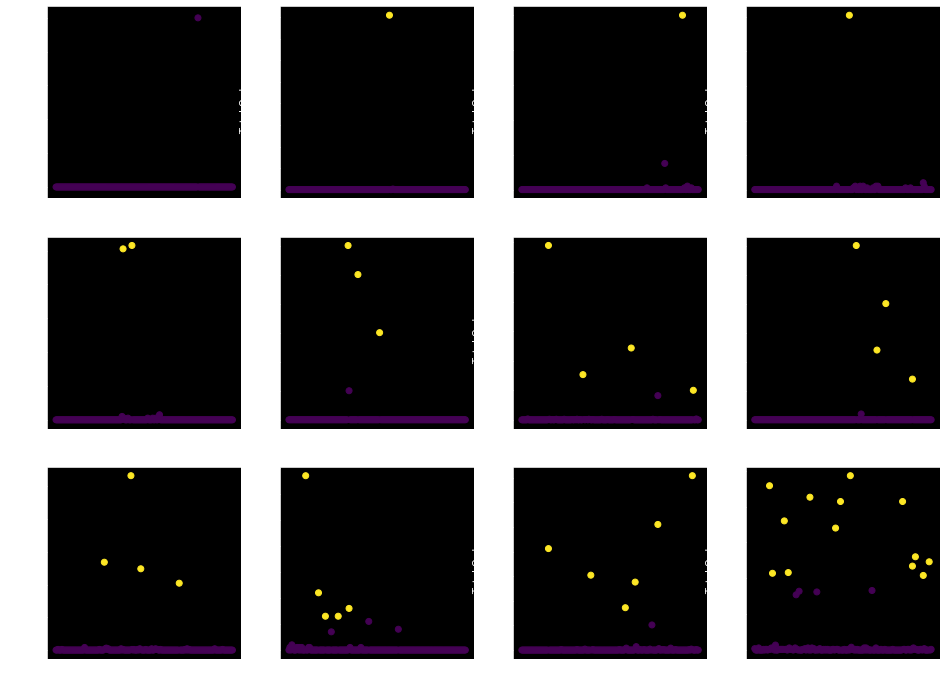

In [18]:
#collapse-hide

# compute promo count
promo_count = agg_orders.groupby('itemID')['promotion'].agg('sum').reset_index()
promo_count = promo_count.sort_values('promotion').reset_index(drop = True)

# plot some items
item_plots = [0, 2000, 4000, 6000, 8000, 9000, 10000, 10100, 10200, 10300, 10400, 10462]
fig = plt.figure(figsize = (16, 12))
for i in range(len(item_plots)):
    plt.subplot(3, 4, i + 1)
    df = agg_orders[agg_orders.itemID == promo_count['itemID'][item_plots[i]]]
    plt.scatter(df['day_of_year'], df['order'], c = df['promotion'])
    plt.ylabel('Total Orders')
    plt.xlabel('Day')

The yellow marker indicates days with promotions. Results suggest that our method identifies some outliers as promotions but misses a few points that are less prominent. At the same time, we can not be sure that these cases are necessarily promotions: the large number of orders on these days could be observed due to other reasons. We will stick to this promotion identification method for now but note that this aspect might require further improvement.

## Feature engineering

Now that the data is aggregated, we can construct transaction-based features as well as the target variable. For each day, we compute target as the total number of orders in the following 14 days. The days preceeding the considered day are used to extract lag-based features. This is done in the computation loop. For each day, we extract slices of the past [1, 7, ..., 35] days and compute features based on data from that slice.

For each item, we construct the following features:
- the total count of orders and the total number of ordered items
- the total count of promotions
- mean item price
- recency of the last order

The number of orders and promotions is also aggregated on a manufacturer and category level.

In addition to the described features, we use `tsfresh` package to automatically extract features based on the `order` time series from the last 35 days. `tsfresh` uses built-in functions to compute hundreds of features describing the time series. After extraction, we only keep features with no missing values for all day-item combinations.

Finally, we compute features based on the two-week for which we predict demand: the number of promotions and mean prices per item, manufacturer and category. 

In [31]:
#collapse-show

# libraries
from tsfresh import extract_featuresfrom tsfresh import extract_features

# parameters
days_input  = [1, 7, 14, 21, 28, 35]
days_target = 14

# preparations
day_first = np.max(days_input)
day_last  = agg_orders['day_of_year'].max() - days_target + 1
orders    = None

# merge manufacturer and category
agg_orders = agg_orders.merge(items[['itemID', 'manufacturer']], how = 'left')
agg_orders = agg_orders.merge(items[['itemID', 'category']],     how = 'left')


# computations
for day_of_year in tqdm(list(range(149, day_last)) + [agg_orders['day_of_year'].max()]):
                

    ###### VALIDAION: TARGET, PROMOTIONS, PRICES
        
    # day intervals
    target_day_min = day_of_year + 1
    target_day_max = day_of_year + days_target
    
    # compute target and promo: labeled data
    if day_of_year < agg_orders['day_of_year'].max():
        
        # target and future promo
        tmp_df = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                            (agg_orders['day_of_year'] <= target_day_max)
                           ].groupby('itemID')['order', 'promotion'].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']
        
        # future price
        tmp_df['mean_price_test'] = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                               (agg_orders['day_of_year'] <= target_day_max)
                                              ].groupby('itemID')['salesPrice'].agg('mean').reset_index()['salesPrice']
        
        # merge manufacturer and category
        tmp_df = tmp_df.merge(items[['itemID', 'manufacturer', 'category']], how = 'left', on = 'itemID')
        
        # future price per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['salesPrice'].agg('mean').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
        
        # future price per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['salesPrice'].agg('mean').reset_index()
        tmp_df_category.columns = ['category', 'mean_price_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
        
        # future promo per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['promotion'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

        # future promo per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['promotion'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'promo_in_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
                       
        
    # compute target and promo: unlabeled data
    else:
        
        # placeholders
        tmp_df = pd.DataFrame({'itemID':                     items.itemID,
                               'target':                     np.nan,
                               'promo_in_test':              np.nan,
                               'mean_price_test':            items.simulationPrice,
                               'manufacturer':               items.manufacturer,
                               'category':                   items.category,
                               'promo_in_test_manufacturer': np.nan,
                               'promo_in_test_category':     np.nan})

        
    ###### TRAINING: LAG-BASED FEATURES
            
    # compute features
    for day_input in days_input:
        
        # day intervals
        input_day_min  = day_of_year - day_input + 1
        input_day_max  = day_of_year
    
        # frequency, promo and price
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('itemID')
        tmp_df['order_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum').reset_index()['order']
        tmp_df['order_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df['promo_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df['mean_price_last_'  + str(day_input)] = tmp_df_input['salesPrice'].agg('mean').reset_index()['salesPrice']

        # frequency, promo per manufacturer
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('manufacturer')
        tmp_df_manufacturer = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'order_manufacturer_sum_last_' + str(day_input)]
        tmp_df_manufacturer['order_manufacturer_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_manufacturer['promo_manufacturer_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
    
        # frequency, promo per category
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('category')
        tmp_df_category = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'order_category_sum_last_' + str(day_input)]       
        tmp_df_category['order_category_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_category['promo_category_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')

        # frequency, promo per all items
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)]
        tmp_df['order_all_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum')
        tmp_df['order_all_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0]))
        tmp_df['promo_all_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum')
        
        # recency
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max) &
                                      (agg_orders['order'] > 0)
                                     ].groupby('itemID')
            tmp_df['days_since_last_order'] = (day_of_year - tmp_df_input['day_of_year'].agg('max')).reindex(tmp_df.itemID).reset_index()['day_of_year']
            tmp_df['days_since_last_order'].fillna(day_input, inplace = True)
            
            
        # tsfresh features
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max)]
            tmp_df_input = tmp_df_input[['day_of_year', 'itemID', 'order']]
            extracted_features = extract_features(tmp_df_input, column_id = 'itemID', column_sort = 'day_of_year')
            extracted_features['itemID'] = extracted_features.index
            tmp_df = tmp_df.merge(extracted_features, how = 'left', on = 'itemID')
            
            
    ###### FINAL PREPARATIONS
            
    # add day of year
    tmp_df.insert(1, column = 'day_of_year', value = day_of_year)
        
    # merge data
    orders = pd.concat([orders, tmp_df], axis = 0)
    
    # drop manufacturer and category
    del orders['manufacturer']
    del orders['category']#collapse-show

# libraries
from tsfresh import extract_featuresfrom tsfresh import extract_features

# parameters
days_input  = [1, 7, 14, 21, 28, 35]
days_target = 14

# preparations
day_first = np.max(days_input)
day_last  = agg_orders['day_of_year'].max() - days_target + 1
orders    = None

# merge manufacturer and category
agg_orders = agg_orders.merge(items[['itemID', 'manufacturer']], how = 'left')
agg_orders = agg_orders.merge(items[['itemID', 'category']],     how = 'left')


# computations
for day_of_year in tqdm(list(range(149, day_last)) + [agg_orders['day_of_year'].max()]):
                

    ###### VALIDAION: TARGET, PROMOTIONS, PRICES
        
    # day intervals
    target_day_min = day_of_year + 1
    target_day_max = day_of_year + days_target
    
    # compute target and promo: labeled data
    if day_of_year < agg_orders['day_of_year'].max():
        
        # target and future promo
        tmp_df = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                            (agg_orders['day_of_year'] <= target_day_max)
                           ].groupby('itemID')['order', 'promotion'].agg('sum').reset_index()
        tmp_df.columns = ['itemID', 'target', 'promo_in_test']
        
        # future price
        tmp_df['mean_price_test'] = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                               (agg_orders['day_of_year'] <= target_day_max)
                                              ].groupby('itemID')['salesPrice'].agg('mean').reset_index()['salesPrice']
        
        # merge manufacturer and category
        tmp_df = tmp_df.merge(items[['itemID', 'manufacturer', 'category']], how = 'left', on = 'itemID')
        
        # future price per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['salesPrice'].agg('mean').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
        
        # future price per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['salesPrice'].agg('mean').reset_index()
        tmp_df_category.columns = ['category', 'mean_price_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
        
        # future promo per manufacturer
        tmp_df_manufacturer = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                         (agg_orders['day_of_year'] <= target_day_max)
                                         ].groupby('manufacturer')['promotion'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

        # future promo per category
        tmp_df_category = agg_orders[(agg_orders['day_of_year'] >= target_day_min) &
                                     (agg_orders['day_of_year'] <= target_day_max)
                                     ].groupby('category')['promotion'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'promo_in_test_category']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')
                       
        
    # compute target and promo: unlabeled data
    else:
        
        # placeholders
        tmp_df = pd.DataFrame({'itemID':                     items.itemID,
                               'target':                     np.nan,
                               'promo_in_test':              np.nan,
                               'mean_price_test':            items.simulationPrice,
                               'manufacturer':               items.manufacturer,
                               'category':                   items.category,
                               'promo_in_test_manufacturer': np.nan,
                               'promo_in_test_category':     np.nan})

        
    ###### TRAINING: LAG-BASED FEATURES
            
    # compute features
    for day_input in days_input:
        
        # day intervals
        input_day_min  = day_of_year - day_input + 1
        input_day_max  = day_of_year
    
        # frequency, promo and price
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('itemID')
        tmp_df['order_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum').reset_index()['order']
        tmp_df['order_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df['promo_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df['mean_price_last_'  + str(day_input)] = tmp_df_input['salesPrice'].agg('mean').reset_index()['salesPrice']

        # frequency, promo per manufacturer
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('manufacturer')
        tmp_df_manufacturer = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_manufacturer.columns = ['manufacturer', 'order_manufacturer_sum_last_' + str(day_input)]
        tmp_df_manufacturer['order_manufacturer_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_manufacturer['promo_manufacturer_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')
    
        # frequency, promo per category
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)
                                 ].groupby('category')
        tmp_df_category = tmp_df_input['order'].agg('sum').reset_index()
        tmp_df_category.columns = ['category', 'order_category_sum_last_' + str(day_input)]       
        tmp_df_category['order_category_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0])).reset_index()['order']
        tmp_df_category['promo_category_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum').reset_index()['promotion']
        tmp_df = tmp_df.merge(tmp_df_category, how = 'left', on = 'category')

        # frequency, promo per all items
        tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                  (agg_orders['day_of_year'] <= input_day_max)]
        tmp_df['order_all_sum_last_'   + str(day_input)] = tmp_df_input['order'].agg('sum')
        tmp_df['order_all_count_last_' + str(day_input)] = tmp_df_input['order'].agg(lambda x: len(x[x > 0]))
        tmp_df['promo_all_count_last_' + str(day_input)] = tmp_df_input['promotion'].agg('sum')
        
        # recency
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max) &
                                      (agg_orders['order'] > 0)
                                     ].groupby('itemID')
            tmp_df['days_since_last_order'] = (day_of_year - tmp_df_input['day_of_year'].agg('max')).reindex(tmp_df.itemID).reset_index()['day_of_year']
            tmp_df['days_since_last_order'].fillna(day_input, inplace = True)
            
            
        # tsfresh features
        if day_input == max(days_input):
            tmp_df_input = agg_orders[(agg_orders['day_of_year'] >= input_day_min) &
                                      (agg_orders['day_of_year'] <= input_day_max)]
            tmp_df_input = tmp_df_input[['day_of_year', 'itemID', 'order']]
            extracted_features = extract_features(tmp_df_input, column_id = 'itemID', column_sort = 'day_of_year')
            extracted_features['itemID'] = extracted_features.index
            tmp_df = tmp_df.merge(extracted_features, how = 'left', on = 'itemID')
            
            
    ###### FINAL PREPARATIONS
            
    # add day of year
    tmp_df.insert(1, column = 'day_of_year', value = day_of_year)
        
    # merge data
    orders = pd.concat([orders, tmp_df], axis = 0)
    
    # drop manufacturer and category
    del orders['manufacturer']
    del orders['category']


##### REMOVE MISSINGS

good_nas = ['target', 
            'mean_price_test_category', 'mean_price_test_manufacturer',
            'promo_in_test', 'promo_in_test_category', 'promo_in_test_manufacturer']
nonas = list(orders.columns[orders.isnull().sum() == 0]) + good_nas
orders = orders[nonas]
print(orders.shape)


##### COMPUTE MEAN PRICE RATIOS

print(orders.shape)
price_vars = ['mean_price_last_1', 'mean_price_last_7', 'mean_price_last_14', 
              'mean_price_last_21', 'mean_price_last_28', 'mean_price_last_35']
for var in price_vars:
    orders['ratio_'              + str(var)] = orders['mean_price_test']              / orders[var]
    orders['ratio_manufacturer_' + str(var)] = orders['mean_price_test_manufacturer'] / orders[var]
    orders['ratio_category_'     + str(var)] = orders['mean_price_test_category']     / orders[var]
print(orders.shape)

(1391579, 458)
(1391579, 470)


The feature extraction takes about ten hours and outputs a data set with 470 features. Great job!

Now, let's create some new features in the `items` dataframe, which provides data on item level. We add the following features:
- ratio of the actual and recommended price
- item category index constructed of three subcategories
- customer rating realtive to the average rating of the items of the same manufacturer
- customer rating realtive to the average rating of the items of the same category

In [ ]:
#collapse-show

# price ratio
items['recommended_simulation_price_ratio'] = items['simulationPrice'] / items['recommendedRetailPrice']

# detailed item category
items['category'] = items['category1'].astype(str) + items['category2'].astype(str) + items['category3'].astype(str)
items['category'] = items['category'].astype(int)

# customer rating ratio per manufacturer
rating_manufacturer = items.groupby('manufacturer')['customerRating'].agg('mean').reset_index()
rating_manufacturer.columns = ['manufacturer', 'mean_customerRating_manufacturer']
items = items.merge(rating_manufacturer, how = 'left', on = 'manufacturer')
items['customerRating_manufacturer_ratio'] = items['customerRating'] / items['mean_customerRating_manufacturer']
del items['mean_customerRating_manufacturer']

# customer rating ratio per category
rating_category = items.groupby('category')['customerRating'].agg('mean').reset_index()
rating_category.columns = ['category', 'mean_customerRating_category']
items = items.merge(rating_category, how = 'left', on = 'category')
items['customerRating_category_ratio'] = items['customerRating'] / items['mean_customerRating_category']
del items['mean_customerRating_category']

We can now merge `orders` and `items`. We also partition the obtained data into the labeled training set and the unlabeled test set, compute some missing features for the test set and export the data as csv files.

In [43]:
#collapse-hide

########## DATA PARTITIONING

# merge data
df = pd.merge(orders, items, on = 'itemID', how = 'left')

# partition intro train and test
df_train = df[df['day_of_year'] <  df['day_of_year'].max()]
df_test  = df[df['day_of_year'] == df['day_of_year'].max()]


########## COMPUTE FEATURES FOR TEST DATA

# add promotion info to test
promo_vars = df_test.filter(like = 'promotion_').columns
df_test['promo_in_test'] = 3 - df_test[promo_vars].isnull().sum(axis = 1)
df_test['promo_in_test'].describe()

del df_test['promo_in_test_manufacturer'], df_test['promo_in_test_category']

# future promo per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['promo_in_test'].agg('sum').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'promo_in_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

# future promo per category
tmp_df_category = df_test.groupby('category')['promo_in_test'].agg('sum').reset_index()
tmp_df_category.columns = ['category', 'promo_in_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')

del df_test['mean_price_test_manufacturer'], df_test['mean_price_test_category']

# future price per manufacturer
tmp_df_manufacturer = df_test.groupby('manufacturer')['mean_price_test'].agg('mean').reset_index()
tmp_df_manufacturer.columns = ['manufacturer', 'mean_price_test_manufacturer']
df_test = df_test.merge(tmp_df_manufacturer, how = 'left', on = 'manufacturer')

# future price per category
tmp_df_category = df_test.groupby('category')['mean_price_test'].agg('mean').reset_index()
tmp_df_category.columns = ['category', 'mean_price_test_category']
df_test = df_test.merge(tmp_df_category, how = 'left', on = 'category')

# mean price ratios
for var in price_vars:
    df_test['ratio_'              + str(var)] = df_test['mean_price_test']              / df_test[var]
    df_test['ratio_manufacturer_' + str(var)] = df_test['mean_price_test_manufacturer'] / df_test[var]
    df_test['ratio_category_'     + str(var)] = df_test['mean_price_test_category']     / df_test[var]


########## DROP FEATURES

# drop promotion dates
df_test.drop(promo_vars,  axis = 1, inplace = True)
df_train.drop(promo_vars, axis = 1, inplace = True)

# drop mean prices
price_vars = price_vars + ['mean_price_test_manufacturer', 'mean_price_test_category']
df_test.drop(price_vars,  axis = 1, inplace = True)
df_train.drop(price_vars, axis = 1, inplace = True)

# export data
save_csv_version('../data/prepared/df.csv',      df_train, index = False, compression = 'gzip')
save_csv_version('../data/prepared/df_test.csv', df_test,  index = False, compression = 'gzip', min_version = 3)
print(df_train.shape)
print(df_test.shape)

Saved as ../data/prepared/df_v14.csv
Saved as ../data/prepared/df_test_v14.csv
(1381116, 476)
(10463, 476)


# 4. Modeling

## Custom loss functions

Mahcine learning encompasses a wide range of statically-inspired performance metrics such as MSE, MAE and others. In practice, machine learning models are used by a company that has specific goals. Usually, these goals can not be expressed in terms of such simple metrics. Therefore, it is important to come up with an evaluation metric that is consistent with the company's objectives to ensure that we judge the model's performance on the criterion that actually matters.

In the DMC 2020 task, we are given a profit function of a retailer who is doing demand forecasting. The function accounts for asymmetric error costs: underpredicting demand results in lost revenue because the retailer can not sell a product that is not ready to ship, whereas overpredicting demand incurs a fee for storing the excessive amount of product. Below, we derive the profit function according to the task description:

![](images/fig_profit_example.png)

Let's implement the profit function in Python so we can use it to estimate the quality of our solution:

In [ ]:
#collapse-show

def profit(y_true, y_pred, price):
    '''
    Computes profit according to DMC 2020 task.
    
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    - price (numpy array or list): item prices.

    Returns:
    - profit value
    '''

    # remove negative and round
    y_pred = np.where(y_pred > 0, y_pred, 0)
    y_pred = np.round(y_pred).astype('int')

    # sold units
    units_sold = np.minimum(y_true, y_pred)

    # overstocked units
    units_overstock = y_pred - y_true
    units_overstock[units_overstock < 0] = 0

    # profit
    revenue = units_sold * price
    fee     = units_overstock * price * 0.6
    profit  = revenue - fee
    profit  = profit.sum()
    
    # return values
    return profit

The function above is great for evaluation. Can we go further and directly optimize it during modeling? 

We will use LightGBM which supports custom loss functions on training and validation stages. In order to use a custom loss on the the training stage, one needs to define a function with its first and second-order derivative matrices (Gradient and Hessian). Unfortunately, the profit function above is not differentiable. This means that we can not compute derivateves necessary to plug this loss into the model. At the same time, we could come up with a different function that approximates the profit and satisfies the loss conditions. 

The profit function has several properties:
- items with higher prices make larger contributions to the profit
- error costs are asymmetric
- costs are linear with respect to the prediction error

Let's address these points one at a time. First, the account for asymmetric error costs is easy to implement: we can do it on top of the standard MSE loss used in regression. To introduce an asymmetric MSE, we need to compute its derivative. This is simple since we only modify MSE by multipling the error by the overstock fee in case of overpredicting.

The snippet below provides two custom asymmetric MSE functions: the first one is used for training the model and the second one is used on validation stage to perform early stopping. The LightGBM requires these two functions to come in a slightly different format:

In [ ]:
# collpase-show

##### TRAINING LOSS
def asymmetric_mse(y_true, y_pred):
    '''
    Asymmetric MSE objective for training Lightgbm regressor.
    
    The asymmetric MSE can be used as a training loss to approximate profit:
     - overpredicting demand by one unit decreases profit by 0.6p
     - underpredicting demand by one unit decreases profit by p
     - hence, overpredicting is 0.6 times less costly
     
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    
    Returns:
    - gradient matrix
    - hessian matrix
    '''
    
    # asymmetry parameter
    fee_mult = 0.6
    
    # computations
    residual = (y_true - y_pred).astype('float')    
    grad = np.where(residual > 0, -2*residual*fee_mult, -2*residual)
    hess = np.where(residual > 0,  2*fee_mult, 2.0)
    
    # return values
    return grad, hess


##### VALIDATION LOSS
def asymmetric_mse_eval(y_true, y_pred):
    
    '''
    Asymmetric MSE evaluation metric for Lightgbm regressor.
     
    Arguments:
    - y_true (numpy array or list): ground truth (correct) target values.
    - y_pred (numpy array or list): estimated target values.
    
    Returns:
    - name of the metric
    - value od the metric
    - whether the metric is maximized
    '''
    
    # asymmetry parameter
    fee_mult = 0.6
    
    # computations
    residual = (y_true - y_pred).astype('float')      
    loss = np.where(residual > 0, (residual**2)*fee_mult, residual**2) 
    return 'asymmetric_mse_eval', np.mean(loss), False

Second, we need to account for item prices. It turns out that LightGBM supports weighting of observations on both training and validation stages! This is done using the arguments `sample_weight` and `eval_sample_weight`. By suppling the price vector for training data as `sample_weight` and the price vector for validation data as `eval_sample_weight`, we can incorporate the price information into the performance evaluation. You will see how we specify this in the modeling code in the next section.

The only missing piece is the relationship between the penalty size and the prediction error. The standard MSE loss takes a square root of the difference between the real and predicted values, which results in penalizing larger errors more than the smaller ones. However, our profit function changes linearly with the error size. 

A simple way to address this would be to switch to MAE, which stands for the mean absolute error. However, MAE suffers from the same problem as the profit function: it is not differentiable and can only be used for evaluation. 

What we can do instead is the following:
- transform target variable using a non-linear transofmration (e.g. square root or logarithm)
- train a model that optimzes the MSE loss on the transformed target variable 
- apply the inverse transofmration to the model predictions

The target transformation smooths out the square effect in the MSE loss. We still penalize large errors more, but the large errors on a transformed scale are also smaller compared to the original scale. This helps to balance out the two effects and approximate a scenario where we want a linear relationship between the error size and the loss penalty.

## Modeling pipeline

Let's start building models! First, we extract the target variable as a vector `y` and flag ID features that are not used for prediction.

In [6]:
#collapse-hide

# extract target
y = df_train['target']
X = df_train.drop('target', axis = 1)
del df_train
print(X.shape, y.shape)

# format test data
X_test = df_test.drop('target', axis = 1)
del df_test
print(X_test.shape)

# relevant features
drop_feats = ['itemID', 'day_of_year']
features = [var for var in X.columns if var not in drop_feats]

(1381116, 475) (1381116,)
(10463, 475)


The modeling pipeline uses multiple tricks discovered during the model refinement process. We toogle these tricks using logical variables that define the following training options:
- `target_transform = True`: transforms a target variabe using a square root transformation to reduce penalty for large errors. This helps to slightly imporve the performance. A detailed motivation for target transofmration is provided in the previous section.
- `train_on_positive = False`: trains a model only on cases with positive sales (i.e., at least one of the order lags is greater than 0) and predicts 0 demand for items with no sales. This substantially reduces the training time but also leads to a drop in the performance.
- `two_stage = True`: trains a two-stage model: first, we fit a binary classifier predicting whether or not the future sales will be zero. Second, we train a regression model predicting the colume of sales. The final prediction is computed as a multiple of the predictions produced by the two models. In other words, predictions of the regression model are only stored for the cases where the classifier predicts positive sales.
- `tuned_params = True`: imports LightGBM hyper-parameter values from the sotred file. The next section provides more detail about the tuning procedure.

We also define the partitioning parameters. We use a sliding window approach with 7 folds, where each subsequent fold is shifted by one day into the past. 

Let's explain the partitioning using one fold as an example. Given a labeled data set with 180 days, we construct the first fold using days 1 - 173. Within the fold, the first 35 days are cut off: they are only used to compute lag-based features for the days starting from 36. Days 36 - 145 are used for training. For each of these days, we have features based on the previous 35 days and targets based on the next 14 days. On validation stage, we use days 159 - 173. Days 146 - 158 between training and validation periods are skipped to avoid data leakage since the target for these dates would use infomration from the validation period.

The partitioning is illustrated below:

![](images/fig_partitioning.png)

In [10]:
# collapse-show

##### DATA PARTITIONING

# paritioning
num_folds = 7   # no. CV folds
test_days = 14  # no. days in the test set

# settings
seed  = 23


##### TRAINING OPTIONS

# target transformation
target_transform = True

# train on positive sales only
train_on_positive = False

# two-stage model
two_stage = True

# use tuned meta-params
tuned_params = True


##### CLASSIFIER PARAMETERS

# rounds and options
cores       = 4
stop_rounds = 100
verbose     = 100

# LGB parameters
lgb_params = {
    'boosting_type':    'goss',
    'objective':        asymmetric_mse,
    'metrics':          asymmetric_mse_eval,
    'n_estimators':     1000,
    'learning_rate':    0.1,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'lambda_l1':        0.1,
    'lambda_l2':        0.1,
    'silent':           True,
    'verbosity':        -1,
    'nthread' :         cores,
    'random_state':     seed,
}

# load optimal parameters
if tuned_params:
    par_file   = open('../lgb_meta_params_100.pkl', 'rb')
    lgb_params = pickle.load(par_file)
    lgb_params['nthread']      = cores
    lgb_params['random_state'] = seed

# second-stage LGB
if two_stage:
    lgb_classifier_params              = lgb_params.copy()
    lgb_classifier_params['objective'] = 'binary'
    lgb_classifier_params['metrics']   = 'logloss'

In [8]:
#collapse-hide

### HELPER FUNCTION TO POSTPROCESS PREDICTIONS

def postprocess_preds(y_pred):
    '''
    Processess demand predictions outputted by a model.
    
    Arguments:
    - y_pred (numpy array or list): estimated target values.

    Returns:
    - corrected y_pred
    '''

    # demand can not be negative
    y_pred = np.where(y_pred > 0, y_pred, 0)
    
    # demand has to be integer
    y_pred = np.round(y_pred).astype('int')

    # return values
    return y_pred

We can now implement the modeling pipeline! We write one master modeling loop. Within the loop, we do the following steps for each of the folds:
- extract data from the fold and partition it into training and validation sets
- train LightGBM on the training set and perform early stopping on the validation set
- save predictions for validation set (denoted as OOF predictions) and predictions for the test set
- save variable importance and performance on the validation fold

In [11]:
# collapse-show

# placeholders
importances   = pd.DataFrame()
preds_oof     = np.zeros((num_folds, items.shape[0]))
reals_oof     = np.zeros((num_folds, items.shape[0]))
prices_oof    = np.zeros((num_folds, items.shape[0]))
preds_test    = np.zeros(items.shape[0])
oof_rmse      = []
oof_profit    = []
oracle_profit = []
clfs          = []
train_idx     = []
valid_idx     = []

# objects
train_days = X['day_of_year'].max() - test_days + 1 - num_folds - X['day_of_year'].min() # no. days in the train set
time_start = time.time()

# modeling loop
for fold in range(num_folds):
    
    ##### PARTITIONING
    
    # validation dates
    if fold == 0:
        v_end = X['day_of_year'].max()
    else:
        v_end = v_end - 1
    v_start = v_end
    
    # training dates
    t_end   = v_start - (test_days + 1)
    t_start = t_end   - (train_days - 1)
    
    # extract index
    train_idx.append(list(X[(X.day_of_year >= t_start) & (X.day_of_year <= t_end)].index))
    valid_idx.append(list(X[(X.day_of_year >= v_start) & (X.day_of_year <= v_end)].index))   
    
    # extract samples
    X_train, y_train = X.iloc[train_idx[fold]][features], y.iloc[train_idx[fold]]
    X_valid, y_valid = X.iloc[valid_idx[fold]][features], y.iloc[valid_idx[fold]]
    X_test = X_test[features]
    
    # keep positive cases
    if train_on_positive:
        y_train = y_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
        X_train = X_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]

    # information
    print('-' * 65)
    print('- train period days: {} -- {} (n = {})'.format(t_start, t_end, len(train_idx[fold])))
    print('- valid period days: {} -- {} (n = {})'.format(v_start, v_end, len(valid_idx[fold])))
    print('-' * 65)

    
    ##### MODELING
    
    # target transformation
    if target_transform:
        y_train = np.sqrt(y_train)
        y_valid = np.sqrt(y_valid)
        
    # first stage model
    if two_stage:
        y_train_binary, y_valid_binary = y_train.copy(), y_valid.copy()
        y_train_binary[y_train_binary > 0] = 1
        y_valid_binary[y_valid_binary > 0] = 1
        clf_classifier = lgb.LGBMClassifier(**lgb_classifier_params) 
        clf_classifier = clf_classifier.fit(X_train, y_train_binary, 
                                            eval_set              = [(X_train, y_train_binary), (X_valid, y_valid_binary)],
                                            eval_metric           = 'logloss',
                                            early_stopping_rounds = stop_rounds,
                                            verbose               = verbose)
        preds_oof_fold_binary  = clf_classifier.predict(X_valid)
        preds_test_fold_binary = clf_classifier.predict(X_test)

    # training
    clf = lgb.LGBMRegressor(**lgb_params) 
    clf = clf.fit(X_train, y_train, 
                  eval_set              = [(X_train, y_train), (X_valid, y_valid)], 
                  eval_metric           = asymmetric_mse_eval,
                  sample_weight         = X_train['simulationPrice'].values,
                  eval_sample_weight    = [X_train['simulationPrice'].values, X_valid['simulationPrice'].values],
                  early_stopping_rounds = stop_rounds,
                  verbose               = verbose)
    clfs.append(clf)
    
    # inference
    if target_transform:      
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid)**2)
        reals_oof_fold  = y_valid**2
        preds_test_fold = postprocess_preds(clf.predict(X_test)**2) / num_folds
    else:
        preds_oof_fold  = postprocess_preds(clf.predict(X_valid))
        reals_oof_fold  = y_valid
        preds_test_fold = postprocess_preds(clf.predict(X_test)) / num_folds
        
    # impute zeros
    if train_on_positive:
        preds_oof_fold[(X_valid['order_sum_last_28'] == 0) & (X_valid['promo_in_test'] == 0)] = 0
        preds_test_fold[(X_test['order_sum_last_28'] == 0) & (X_test['promo_in_test']  == 0)] = 0
        
    # multiply with first stage predictions
    if two_stage:
        preds_oof_fold  = preds_oof_fold  * np.round(preds_oof_fold_binary)
        preds_test_fold = preds_test_fold * np.round(preds_test_fold_binary)

    # write predictions
    preds_oof[fold, :] = preds_oof_fold
    reals_oof[fold, :] = reals_oof_fold
    preds_test        += preds_test_fold
    
    # save prices
    prices_oof[fold, :] = X.iloc[valid_idx[fold]]['simulationPrice'].values
        
        
    ##### EVALUATION

    # evaluation
    oof_rmse.append(np.sqrt(mean_squared_error(reals_oof[fold, :], 
                                               preds_oof[fold, :])))
    oof_profit.append(profit(reals_oof[fold, :], 
                             preds_oof[fold, :], 
                             price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    oracle_profit.append(profit(reals_oof[fold, :], 
                                reals_oof[fold, :], 
                                price = X.iloc[valid_idx[fold]]['simulationPrice'].values))
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['Importance'] = clf.feature_importances_
    fold_importance_df['Fold'] = fold + 1
    importances = pd.concat([importances, fold_importance_df], axis = 0)
    
    # information
    print('-' * 65)
    print('FOLD {:d}/{:d}: RMSE = {:.2f}, PROFIT = {:.0f}'.format(fold + 1, 
                                                                  num_folds, 
                                                                  oof_rmse[fold], 
                                                                  oof_profit[fold]))
    print('-' * 65)
    print('')
    

# print performance
print('')
print('-' * 65)
print('- AVERAGE RMSE:   {:.2f}'.format(np.mean(oof_rmse)))
print('- AVERAGE PROFIT: {:.0f} ({:.2f}%)'.format(np.mean(oof_profit), 100 * np.mean(oof_profit) / np.mean(oracle_profit)))
print('- RUNNING TIME:   {:.2f} minutes'.format((time.time() - time_start) / 60))
print('-' * 65)

-----------------------------------------------------------------
- train period days: 41 -- 151 (n = 1161393)
- valid period days: 166 -- 166 (n = 10463)
-----------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.29915	valid_1's binary_logloss: 0.384927
[200]	training's binary_logloss: 0.264402	valid_1's binary_logloss: 0.356034
[300]	training's binary_logloss: 0.252268	valid_1's binary_logloss: 0.349405
[400]	training's binary_logloss: 0.245571	valid_1's binary_logloss: 0.347868
[500]	training's binary_logloss: 0.24001	valid_1's binary_logloss: 0.347445
[600]	training's binary_logloss: 0.235189	valid_1's binary_logloss: 0.347438
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.238417	valid_1's binary_logloss: 0.347182
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.98306	training's asymmetric_mse_eval: 2.75817	valid_1's rm

Looks good! The modeling loop took us two hours to run. 

Forecasting demand with our models results in 3,995,840 profit per day, which is about 54% of the maximum possible profit. Let's now visualize the performance of our models:

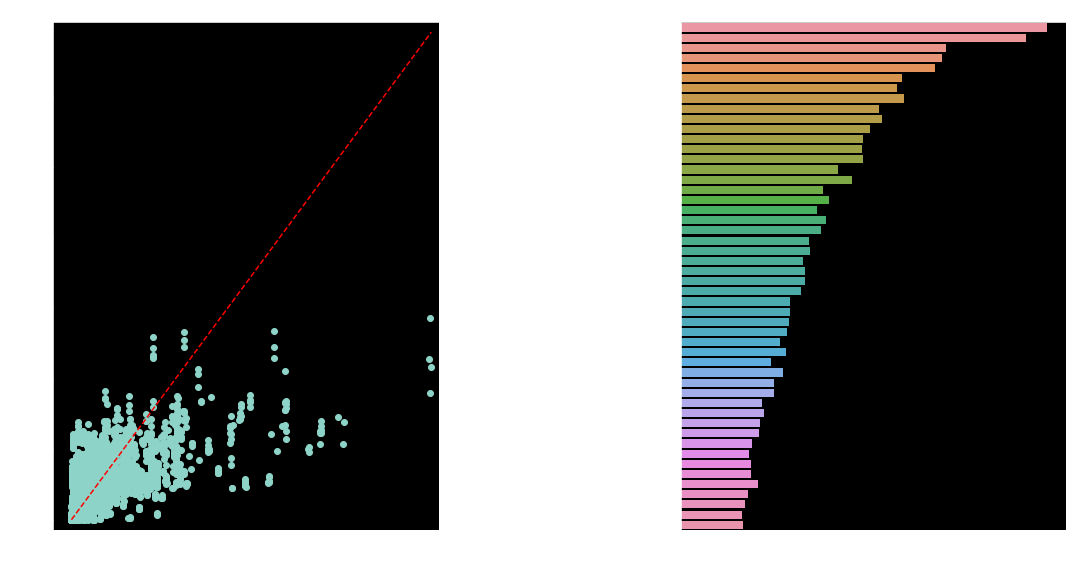

In [12]:
# collapse-hide

fig = plt.figure(figsize = (15, 8))

# residual plot
plt.subplot(1, 2, 1)
plt.scatter(reals_oof.reshape(-1), preds_oof.reshape(-1))
axis_lim = np.max([reals_oof.max(), preds_oof.max()])
plt.ylim(top   = 1.02*axis_lim)
plt.xlim(right = 1.02*axis_lim)
plt.plot((0, axis_lim), (0, axis_lim), 'r--')
plt.title('Residual Plot')
plt.ylabel('Predicted demand')
plt.xlabel('Actual demand')

# feature importance
plt.subplot(1, 2, 2)
top_feats = 50
cols = importances[['Feature', 'Importance']].groupby('Feature').mean().sort_values(by = 'Importance', ascending = False)[0:top_feats].index
importance = importances.loc[importances.Feature.isin(cols)]
sns.barplot(x = 'Importance', y = 'Feature', data = importance.sort_values(by = 'Importance', ascending = False), ci = 0)
plt.title('Feature Importance')
plt.tight_layout()

The scatterplot shows that there is a space for further improvement as there are many predictions far from the 45-degree line where predictions and real orders are equal. As expected, the model overpredicts demand more frequently than underpredicting due to the structure of the loss. The important features mostly contain price information followed by features that count the number of previous orders.

We can now use predictions stored as `preds_test` to predict future demand. Mission acomplished!

# 4. Hyper-parameter tuning

One way to improve our solution is to optimize the hyper-parameters of the LightGBM model used to make predictions.

This section describes how to tune hyper-parameters using the `hyperopt` package, which performs optimization using Tree of Parzen Estimators (TPE) as a search algorithm. You don't really need to know how TPE works. As a user, you are only required to supply the hyper-parameter grid indicating the range of possible values. Compared to standard tuning methods like grid search or random search, TPE explores the search space more efficiently, allowing you to find a suitable solution faster. If you want to read more, please see the package documentation [here](http://hyperopt.github.io/hyperopt/). 

So, let's specify hyper-parameter ranges! Below, we create a dictionary of LightGBM hyper-parameters using three options:
- `hp.choice('name', list_of_values)`: sets hyper-parameter to one of the list values. This is suitable for hyper-parameters that can have multiple distinct values like `boosting_type`.
- `hp.uniform('name', min, max)`: sets hyper-paramater to a float value between `min` and `max`. This works well with hyper-parameters such as `learning_rate`.
- `hp.quniform('name', min, max, step)`: sets hyper-parameter to a value between `min` and `max` with a step size of `step`. This is useful for integer parameters like `max_depth`.

In [8]:
#collapse-show

# boosting types
boost_types = ['gbdt', 'goss']

# training params
lgb_reg_params = {    
    'boosting_type':    hp.choice('boosting_type', boost_types),    
    'objective':        'rmse',
    'metrics':          'rmse',
    'n_estimators':     10000,
    'learning_rate':    hp.uniform('learning_rate',  0.0001, 0.3),
    'max_depth':        hp.quniform('max_depth',          1,  16, 1),
    'num_leaves':       hp.quniform('num_leaves',        10,  64, 1),
    'bagging_fraction': hp.uniform('bagging_fraction',  0.3,   1),
    'feature_fraction': hp.uniform('feature_fraction',  0.3,   1),
    'lambda_l1':        hp.uniform('lambda_l1',           0,   1),
    'lambda_l2':        hp.uniform('lambda_l2',           0,   1),
    'silent':           True,
    'verbosity':        -1,
    'nthread' :         4,
    'random_state':     77,
}

# evaluation params
lgb_fit_params = {
    'eval_metric':           'rmse',
    'early_stopping_rounds': 100,
    'verbose':               False,
}

# combine params
lgb_space = dict()
lgb_space['reg_params'] = lgb_reg_params
lgb_space['fit_params'] = lgb_fit_params

Next, we create an `HPOpt` object that performs tuning given the data. We define three functions: 
- `process`: runs the optimization process. By default, `HPO` uses `fmin()` to minimize the specified objective.
- `lgb_reg`: initializes LighGBM with the specified hyper-parameters.
- `train_reg`: trains LightGBM and computes the loss. Since we aim to maximize profit, we simply define loss as negative profit.

In [9]:
# collapse-show

class HPOpt(object):

    # INIT
    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test

    # optimization process
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn        = fn, 
                          space     = space, 
                          algo      = algo, 
                          max_evals = max_evals, 
                          trials    = trials)
        except Exception as e:
            return {'status': STATUS_FAIL, 'exception': str(e)}
        return result, trials
    
    
    # LGBM INITIALIZATION
    def lgb_reg(self, para):
        para['reg_params']['max_depth']  = int(para['reg_params']['max_depth'])
        para['reg_params']['num_leaves'] = int(para['reg_params']['num_leaves'])
        reg = lgb.LGBMRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    
    # TRAINING AND INFERENCE
    def train_reg(self, reg, para):
        
        # fit LGB
        reg.fit(self.x_train, self.y_train,
                eval_set              = [(self.x_train, self.y_train), (self.x_test, self.y_test)], 
                sample_weight         = self.x_train['simulationPrice'].values,
                eval_sample_weight    = [self.x_train['simulationPrice'].values, self.x_test['simulationPrice'].values],
                **para['fit_params'])
        
        # inference
        if target_transform:      
            preds = postprocess_preds(reg.predict(self.x_test)**2)
            reals = self.y_test**2
        else:
            preds = postprocess_preds(reg.predict(self.x_test))
            reals = self.y_test
        
        # impute zeros
        if train_on_positive:
            preds[(self.x_test['order_sum_last_28'] == 0) & (self.x_test['promo_in_test'] == 0)] = 0

        # compute loss [negative profit]
        loss = np.round(-profit(reals, preds, price = self.x_test['simulationPrice'].values))
                      
        return {'loss': loss, 'status': STATUS_OK}

Since we aim to use the tuned hyper-parameter values for our model, we would need to perform tuning on a differet subset of data to prevent overfitting. To that end, we will simply go one day in the past compared to the training folds used in the previous section.

In [10]:
# collapse-hide

# validation dates
v_end   = 158          # 1 day before last validation fold in code_03_modeling
v_start = v_end        # same as v_start

# training dates
t_start = 28           # first day in the data
t_end   = v_start - 15 # validation day - two weeks

# extract index
train_idx = list(X[(X.day_of_year >= t_start) & (X.day_of_year <= t_end)].index)
valid_idx = list(X[(X.day_of_year >= v_start) & (X.day_of_year <= v_end)].index)   

# extract samples
X_train, y_train = X.iloc[train_idx][features], y.iloc[train_idx]
X_valid, y_valid = X.iloc[valid_idx][features], y.iloc[valid_idx]

# keep positive cases
if train_on_positive:
    y_train = y_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
    X_train = X_train.loc[(X_train['order_sum_last_28'] > 0) | (X_train['promo_in_test'] > 0)]
    
# target transformation
if target_transform:
    y_train = np.sqrt(y_train)
    y_valid = np.sqrt(y_valid)

# information
print('-' * 65)
print('- train period days: {} -- {} (n = {})'.format(t_start, t_end, len(train_idx)))
print('- valid period days: {} -- {} (n = {})'.format(v_start, v_end, len(valid_idx)))
print('-' * 65)

-----------------------------------------------------------------
- train period days: 28 -- 143 (n = 1213708)
- valid period days: 158 -- 158 (n = 10463)
-----------------------------------------------------------------


Now, we just need to instantiate the `HPOpt` object and launch the tuning trials! Let's do that and then extract optimal values as a dictionary:

In [13]:
# collapse-show

# instantiate objects
hpo_obj = HPOpt(X_train, X_valid, y_train, y_valid)
trials  = Trials() 

# perform tuning
lgb_opt_params = hpo_obj.process(fn_name   = 'lgb_reg',
                                 space     = lgb_space, 
                                 trials    = trials, 
                                 algo      = tpe.suggest, 
                                 max_evals = tuning_trials)  

# merge best params to fixed params
params = list(lgb_opt_params[0].keys())
for par_id in range(len(params)):
    lgb_reg_params[params[par_id]] = lgb_opt_params[0][params[par_id]]
    
# postprocess
lgb_reg_params['boosting_type'] = boost_types[lgb_reg_params['boosting_type']]
lgb_reg_params['max_depth']     = int(lgb_reg_params['max_depth'])
lgb_reg_params['num_leaves']    = int(lgb_reg_params['num_leaves'])

# print best params
print('Best meta-parameters:')
lgb_reg_params

Best meta-parameters:


{'boosting_type': 'goss',
 'objective': 'rmse',
 'metrics': 'rmse',
 'n_estimators': 10000,
 'learning_rate': 0.004012417857266637,
 'max_depth': 10,
 'num_leaves': 64,
 'bagging_fraction': 0.9346881591116736,
 'feature_fraction': 0.6680768850934483,
 'lambda_l1': 0.28013320828944976,
 'lambda_l2': 0.5896826524767101,
 'silent': True,
 'verbosity': -1,
 'nthread': 4,
 'random_state': 77}

Done! Now we can simply save the hyper-parameter values as a `pickle` file and load them in the modeling script when setting up the model. 

In [16]:
# collapse-show

par_file = open('../lgb_meta_params.pkl', 'wb')
pickle.dump(lgb_reg_params, par_file)
par_file.close()

# 5. Closing words

This blogpost has finally come to an end. Thank you for reading! We looked at important stages of our solution and covered steps such as data aggregation, feature engineering, custom loss functions, target transformation and hyper-parameter tuning in detail.

Our final solution is an ensemble of multiple LightGBM models with different features and training options that we have developed during the competition. I am not covering the ensembling part in the blogpost, but you can find the blending and stacking codes along with the other notebooks in my [Github repo](https://github.com/kozodoi/DMC_2020).

If you liked the task, stay tuned for the next editions of the [Data Mining Cup](https://www.data-mining-cup.com) and feel free to use the comment widnow below to ask questions if something is not clear.